# Sea ice drift

This notebook plots NSIDC sea ice drift vectors. 
 
**Input**:
 - NETCDF4 file from the jupyter book's google bucket
 
 
 **Output**: 
  - Plots of sea ice drift

```{tip}
Try running this notebook in Google Colab! Toggle over the rocketship icon at the top of the page and click Colab to open a new window and run the notebook. <br><br>To run a single cell, type **Shift+Enter**. To run the whole notebook, under **Runtime** click **Run all**. Note that you will have to run the notebook from the very beginning and load all the Google Colab dependencies for the code to work.
```

In [1]:
#this cell will load dependencies for running the notebook in Google Colab
#this cell may take a while to run
import sys

#if code is running in google colab, run these cells to install neccessary libraries
if 'google.colab' in sys.modules: 
    !apt-get install -qq libgdal-dev libproj-dev
    !pip install --no-binary shapely shapely --force
    !pip install -q pyproj
    !pip install cartopy
    !pip install netcdf4
    !pip install xarray==0.16.0
    !pip install nbimporter

## Import notebook dependencies

In [2]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj
from textwrap import wrap

#axes needed for plotting
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

# Ignore warnings in the notebook to improve display
# You might want to remove this when debugging/writing new code
import warnings
warnings.filterwarnings('ignore')
 
#increase resolution for notebook outputs
%matplotlib inline 
%config InlineBackend.figure_format = 'retina' 

#import package that allows you to use functions from other jupyter notebooks
import nbimporter

### Import functions from other notebooks in the jupyter book 
This is done using the nbimporter packed installed in the cell above.

In [3]:
from mapping import getWinterDateRange

Importing Jupyter notebook from mapping.ipynb


## Load data into notebook
Copy file from the book's google bucket and load into an xarray dataset. 

In [4]:
!gsutil -m cp gs://icesat2-book-data/icesat2-book-winter-data.nc ./
dataset = xr.open_dataset('icesat2-book-winter-data.nc')

Copying gs://icesat2-book-data/icesat2-book-winter-data.nc...
\ [1/1 files][163.4 MiB/163.4 MiB] 100% Done                                    
Operation completed over 1 objects/163.4 MiB.                                    


## Plot one month of drift data 

### Define function

In [17]:
def plotDriftsOneMonth(dataset, dataVar, month, minval = 0, maxval = None, cbarTicks = None, cmap = 'YlGnBu', res = 4, scale_vec = 100, vector_val = 10): 
    """Plots map of the arctic on North Pole Stereo projection with one month of data and drift vectors overlayed.
   
    Args:
        dataset (xr Dataset): dataset from google bucket
        dataVar (str): data variable of interest, to overlay vectors on
        month (str): month and year of interest, i.e. 'Dec 2019' (does not need to be in any particular format)
        minval (int): minimum drift value (default to 0 cm)
        minval (int): maximum drift value (default to 15 cm)
        cbarTicks (list or np array of length 2): ticks to use on colorbar (default to [0,5,10,15])
        cmap (str, optional): color map (default to GnBu)
        res (int): resolution to display vectors (default to 4)
        scale_vec (int): scaling value for displaying vectors (default to 100)
        vector_val (int): value of vector to display in quiver key (default to 10 cm)
        
    Returns:
        Figure displayed in notebook 
    
    Note: 
        Follows method from https://github.com/SciTools/cartopy/issues/1179
    """
    #define projection and transform
    proj = ccrs.NorthPolarStereo(central_longitude = -45)
    transform = ccrs.PlateCarree()
    
    #initialize the figure and axes 
    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection = proj)
    
    #plot vector magnitudes 
    uvelT = dataset.sel(time = month)['drifts_uT'].values[0]
    vvelT = dataset.sel(time = month)['drifts_vT'].values[0]
    
    #define cbarTicks
    cbarTicks = np.arange(minval, maxval + 1, 1) if cbarTicks is None else cbarTicks
    
    #plot data 
    im = dataset[dataVar].where(dataset['seaice_conc_monthly_cdr'] > 0.5).sel(time = month).plot(x = 'longitude', y = 'latitude', vmin = minval, 
                                vmax = maxval, extend = 'both', ax = ax, add_colorbar = False, transform = transform, zorder = 2, cmap = cmap)
    #add title
    ax.set_title("\n".join(wrap(month + ": Drift vectors overlayed on " + dataset[dataVar].attrs['long_name'], 36)), fontsize = 'x-large')
    
    #plot vectors 
    u_src_crs = uvelT / np.cos(dataset.latitude.values / 180 * np.pi)
    v_src_crs = vvelT
    magn_src_crs = np.sqrt(u_src_crs**2 + v_src_crs**2)
    var_u_scaled = u_src_crs * dataset['drifts_magnitude'].sel(time = month).values[0] / magn_src_crs
    var_v_scaled = v_src_crs * dataset['drifts_magnitude'].sel(time = month).values[0] / magn_src_crs
    
    #add quiver key
    Q = ax.quiver(dataset.longitude.values[::res, ::res], dataset.latitude.values[::res, ::res], var_u_scaled[::res, ::res], 
        var_v_scaled[::res, ::res], transform = transform, units = 'inches', scale = scale_vec, zorder = 5)
    qk = plt.quiverkey(Q, 0.9, 0.9, vector_val, str(vector_val) + ' ' + dataset['drifts_uT'].attrs['units'], coordinates = 'axes', zorder = 11, fontproperties = {'size': 12})   
    
    #add features to the map
    ax.coastlines(linewidth = 0.15, color = 'black', zorder = 10) #add coastlines 
    ax.add_feature(cfeature.LAND, color ='0.95', zorder = 5) #add land 
    #ax.add_feature(cfeature.LAKES, color = 'grey', zorder = 5) #add lakes 
    ax.gridlines(draw_labels = False, linewidth = 0.25, color = 'gray', alpha = 0.7, linestyle = '--', zorder = 6) #add gridlines
    ax.set_extent([-179, 179, 55, 90], crs = transform) #zoom in so map only displays the Arctic
    
    #add colorbar
    cax = fig.add_axes([0.22, 0.08, 0.6, 0.03])
    cb = fig.colorbar(im, cax = cax, extend = 'both',orientation = 'horizontal')
    cb.set_label("\n".join(wrap(dataset[dataVar].attrs['long_name'] + ' (' + dataset[dataVar].attrs['units'] + ')', 40)))
    cb.set_ticks(cbarTicks)
    
    #display figure in notebook 
    plt.show()

### Call function

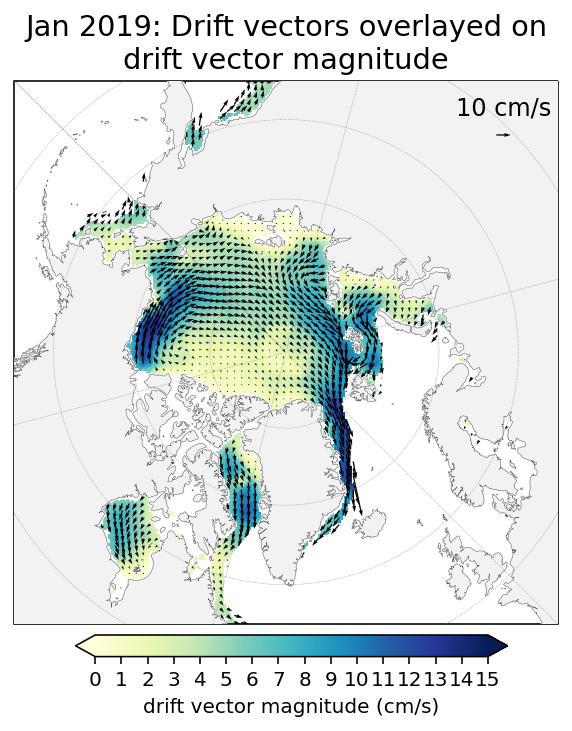

In [19]:
plotDriftsOneMonth(dataset, dataVar = 'drifts_magnitude', month = 'Jan 2019', maxval = 15)

## Plot winter data
 - This function is modified from the plotDriftsOneMonth function above to plot 6 months of data instead of one
 - Winter is defined as the months Nov, Dec, Jan, Feb, Mar, Apr

### Define function